In [201]:
import torch
print(torch.__version__)
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from __future__ import annotations
import torch.nn as nn
import torch.optim as optim


1.11.0+cpu


In [228]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dirs, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        class_val = -1;     count = 0
        class_vals = self.img_labels['Label'].value_counts(ascending=True).values
        
        while  (idx > class_val):
            class_val+=class_vals[count]
            count+=1
        count -=1   
        img_path = os.path.join(self.img_dirs[count], self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def build_dataset(data_path,classes,dataset_name,dataset_transforms):
    labels_df = pd.DataFrame()
    list_img_dirs =[]
    i =0
    list_files = np.array([]);   list_labels = np.array([])
    for class_name in list(classes.values()):
        class_path = data_path + class_name +"/"
        list_img_dirs.append(class_path)
        for dir in os.listdir(class_path):
            list_files = np.append(list_files,dir)
            list_labels= np.append(list_labels,int(i))
        i+=1
        labels_df = pd.DataFrame({"Filename":list_files,"Label":list_labels.astype(int)})
    labels_df.to_csv(dataset_name, index = False)
    
    dataset = CustomImageDataset(annotations_file=dataset_name,img_dirs=list_img_dirs,transform= dataset_transforms)   
    
    return dataset

In [229]:
severity_train_path = "C:/Users/louis/thesis/cars data/data3a/training/"
severity_valid_path = "C:/Users/louis/thesis/cars data/data3a/validation/"

severity_classes = {0:'01-minor',1:'02-moderate',2:'03-severe'}
location_classes = {0:'front',1:'back',2:'side'}

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    torchvision.transforms.Resize((288,288)),
    #T.RandomResizedCrop(image_size), # data augmentation
    # T.RandomHorizontalFlip(),
    transforms.ToTensor()])

train_severity_ds = build_dataset(severity_train_path,severity_classes,"train_severity",train_transforms)
valid_severity_ds = build_dataset(severity_valid_path,severity_classes,"valid_severity",train_transforms)

batch_size = 4

trainloader = torch.utils.data.DataLoader(train_severity_ds, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(valid_severity_ds, batch_size=batch_size, shuffle=False)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# # get some random training images
# dataiter = iter(trainloader)

# # for images, labels in dataiter:
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels

# print(' '.join(f'{classes[labels[j].item()]}' for j in range(batch_size)))

In [136]:
# https://pytorch.org/vision/stable/models.html
from torchvision.models import resnet50

model = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\louis/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.53MB/s]


In [247]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html see train on gpu
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

PATH = './resnet.pth'
torch.save(model.state_dict(), PATH)

[1,   100] loss: 0.029
[1,   200] loss: 0.031
[2,   100] loss: 0.026
[2,   200] loss: 0.025
[3,   100] loss: 0.022
[3,   200] loss: 0.021
[4,   100] loss: 0.015
[4,   200] loss: 0.018
[5,   100] loss: 0.016
[5,   200] loss: 0.011
[6,   100] loss: 0.015
[6,   200] loss: 0.014
[7,   100] loss: 0.014
[7,   200] loss: 0.013
[8,   100] loss: 0.017
[8,   200] loss: 0.011
[9,   100] loss: 0.011
[9,   200] loss: 0.006
[10,   100] loss: 0.007
[10,   200] loss: 0.009
Finished Training


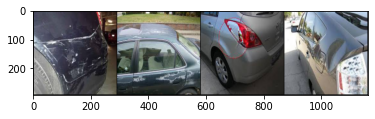

GroundTruth:  01-minor 01-minor 01-minor 01-minor


In [248]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{severity_classes[labels[j].item()]}' for j in range(4)))

In [249]:
net = resnet50()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [250]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{severity_classes[predicted[j].item()]}'
                              for j in range(4)))

Predicted:  03-severe 02-moderate 01-minor 01-minor


In [251]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print(f"Majority vote accuracy: {labels_df['Label'].value_counts().max()/labels_df['Label'].value_counts().sum()}%")

Accuracy of the network on the 10000 test images: 47 %
Majority vote accuracy: 0.39427987742594484%


In [246]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in list(severity_classes.values())}
total_pred = {classname: 0 for classname in list(severity_classes.values())}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[list(severity_classes.values())[label]] += 1
            total_pred[list(severity_classes.values())[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 01-minor is 27.1 %
Accuracy for class: 02-moderate is 20.0 %
Accuracy for class: 03-severe is 57.4 %
